In [69]:
# import statments
import pandas as pd
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
from collections import defaultdict

In [70]:
#global variables
renamed_stocks = {"FB": "META"}
failed_downloads = []
cutoff_date = pd.to_datetime('2017-01-01')

#Import raw data
df = pd.read_csv("../congress_trades.csv")

#Clean data
df["ReportDate"] = pd.to_datetime(df["ReportDate"])
df["TransactionDate"] = pd.to_datetime(df["TransactionDate"])

df = df.loc[df["TransactionDate"] > cutoff_date]
df.loc[~df["Transaction"].str.contains("Purchase"), "Amount"] = - df["Amount"]
df["Ticker"] = df["Ticker"].replace(renamed_stocks)
df.sort_values("TransactionDate", ascending=True, inplace=True)

In [71]:
#partition dataframe
portfolio = df.loc[(df["Representative"] == "Nancy Pelosi")]
portfolio.head(3)

,Representative,ReportDate,TransactionDate,Ticker,Transaction,Range,House,Amount,Party,last_modified
35009,Nancy Pelosi,2017-02-14,2017-01-19,AAPL,Purchase,"$500,001 - $1,000,000",Representatives,500001.0,D,2023-11-16
34993,Nancy Pelosi,2017-02-14,2017-01-20,AAPL,Sale,"$250,001 - $500,000",Representatives,-250001.0,D,2023-11-16
35004,Nancy Pelosi,2017-02-14,2017-01-20,SQ,Purchase,"$15,001 - $50,000",Representatives,15001.0,D,2023-11-16


In [72]:
#Download and store SPY stock data
end_date = datetime.today().strftime('%Y-%m-%d')
stock_data = yf.download("SPY", start=cutoff_date, end=end_date, auto_adjust=True, rounding=True, progress=False) #maybe use back_adjust=True? dunno
stock_data["Ticker"] = "SPY"
stock_data = stock_data[["Ticker", "Close"]]
stock_data

,Ticker,Close
Date,,
2017-01-03,SPY,197.95
2017-01-04,SPY,199.13
2017-01-05,SPY,198.97
2017-01-06,SPY,199.68
2017-01-09,SPY,199.03
...,...,...
2024-10-31,SPY,568.64
2024-11-01,SPY,571.04
2024-11-04,SPY,569.81


In [73]:
#Download and store AAPL and DIS stock data
tickers = portfolio["Ticker"].unique().tolist()
stocks = yf.download(tickers, start=cutoff_date, end=end_date, auto_adjust=True, rounding=True, progress=False)
stocks_close = stocks['Close']
formatted_stocks = stocks_close.reset_index().melt(id_vars=['Date'], var_name='Ticker', value_name='Close')
formatted_stocks = formatted_stocks.dropna(subset=['Close'])
formatted_stocks.set_index("Date", inplace=True)
stock_data = pd.concat([stock_data, formatted_stocks])
stock_data = stock_data.sort_values(by=['Ticker', 'Date'])
stock_data["DailyROI"] = stock_data.groupby('Ticker')['Close'].pct_change().fillna(0) + 1.0
stock_data


2 Failed downloads:
['WORK', 'MONTGOMERY, AL .2, SCHAUMBERG, IL .1']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


,Ticker,Close,DailyROI
Date,,,
2017-01-03,AAPL,26.92,1.000000
2017-01-04,AAPL,26.89,0.998886
2017-01-05,AAPL,27.03,1.005206
2017-01-06,AAPL,27.33,1.011099
2017-01-09,AAPL,27.58,1.009147
...,...,...,...
2024-10-31,WBD,8.13,1.046332
2024-11-01,WBD,8.23,1.012300
2024-11-04,WBD,8.17,0.992710


In [74]:
#reset index for merging
stock_data.reset_index(inplace=True)

In [75]:
#add price and stock amount data for each transaction
portfolio = portfolio.merge(stock_data, how='left', left_on=['TransactionDate', 'Ticker'], right_on=['Date', 'Ticker'])
portfolio.drop(columns=['Date', "DailyROI"], inplace=True)
portfolio["StockAmount"] = portfolio["Amount"]/portfolio["Close"]
portfolio.head()

,Representative,ReportDate,TransactionDate,Ticker,Transaction,Range,House,Amount,Party,last_modified,Close,StockAmount
0,Nancy Pelosi,2017-02-14,2017-01-19,AAPL,Purchase,"$500,001 - $1,000,000",Representatives,500001.0,D,2023-11-16,27.76,18011.563401
1,Nancy Pelosi,2017-02-14,2017-01-20,AAPL,Sale,"$250,001 - $500,000",Representatives,-250001.0,D,2023-11-16,27.81,-8989.608055
2,Nancy Pelosi,2017-02-14,2017-01-20,SQ,Purchase,"$15,001 - $50,000",Representatives,15001.0,D,2023-11-16,14.89,1007.454668
3,Nancy Pelosi,2017-07-20,2017-06-15,AAPL,Purchase,"$500,001 - $1,000,000",Representatives,500001.0,D,2023-11-16,33.73,14823.628817
4,Nancy Pelosi,2017-07-20,2017-06-20,BFET,Sale,"$1,001 - $15,000",Representatives,-1001.0,D,2023-11-16,1.20,-834.166667


In [76]:
def holdings(trades, groupby_column = "TransactionDate"):
    dates = yf.download("SPY", start=cutoff_date, end=end_date, auto_adjust=True, rounding=True, progress=False).index.strftime("%Y-%m-%d")
    dates = pd.to_datetime(dates)

    cumulative_holdings = defaultdict(int)
    holdings_list = []

    trades_grouped = trades.groupby(groupby_column)

    for date in dates:
        if date in trades_grouped.groups:
            day_transactions = trades_grouped.get_group(date)

            # Efficiently update cumulative holdings
            for ticker, stock_amount in day_transactions.groupby('Ticker')['StockAmount'].sum().items():
                cumulative_holdings[ticker] += stock_amount
                if cumulative_holdings[ticker] <= 0:
                    del cumulative_holdings[ticker]

        # Append the current state of holdings to the list
        for ticker, stock_amount in cumulative_holdings.items():
            holdings_list.append({
                'Date': date,
                'Ticker': ticker,
                'StockAmount': stock_amount,
            })

    # Convert the holdings list to a DataFrame
    holdings_df = pd.DataFrame(holdings_list)

    return holdings_df 

In [77]:
myholdings = holdings(portfolio)

In [78]:
myholdings = myholdings.merge(stock_data, left_on=['Date', 'Ticker'], right_on=['Date', 'Ticker'], how="left")
myholdings["StockValue"] = myholdings["StockAmount"] * myholdings["Close"]

In [79]:
spy_data = yf.download("SPY", start=cutoff_date, end=end_date, auto_adjust=True, rounding=True, progress=False)
spy_data["DailyROI"] = spy_data["Close"].pct_change().fillna(0) + 1.0
spy_data["SPYCumROI"] = spy_data["DailyROI"].cumprod()
spy_data.reset_index(inplace=True)
spy_data

,Date,Open,High,Low,Close,Volume,DailyROI,SPYCumROI
0,2017-01-03,197.78,198.47,196.76,197.95,91366500,1.000000,1.000000
1,2017-01-04,198.29,199.28,198.28,199.13,78744400,1.005961,1.005961
2,2017-01-05,198.86,199.13,198.16,198.97,78379000,0.999197,1.005153
3,2017-01-06,199.09,200.16,198.53,199.68,71559900,1.003568,1.008740
4,2017-01-09,199.42,199.56,198.99,199.03,46939700,0.996745,1.005456
...,...,...,...,...,...,...,...,...
1970,2024-10-31,575.56,575.63,568.44,568.64,60182500,0.980397,2.872645
1971,2024-11-01,571.32,575.55,570.62,571.04,45667500,1.004221,2.884769
1972,2024-11-04,571.18,572.50,567.89,569.81,38217000,0.997846,2.878555
1973,2024-11-05,570.74,576.74,570.52,576.70,39478300,1.012092,2.913362


In [80]:
# Calculate total value for each date
myholdings['TotalValue'] = myholdings.groupby('Date')['StockValue'].transform('sum')

# Calculate weighted ROI
myholdings['WeightedROI'] = myholdings['StockValue'] / myholdings['TotalValue'] * myholdings['DailyROI']

In [81]:

# Calculate portfolio ROI
portfolio_roi = spy_data[["Date", "SPYCumROI"]]


portfolio_roi = portfolio_roi.merge(myholdings.groupby('Date')['WeightedROI'].sum().reset_index(), on="Date", how="left")
portfolio_roi.columns = ['Date', "SPYCumROI", 'PortfolioROI']  # Rename the merged column
portfolio_roi['PortfolioROI'] = portfolio_roi['PortfolioROI'].fillna(1.0)

portfolio_roi["CumulativeROI"] = portfolio_roi["PortfolioROI"].cumprod()

In [82]:
copytraded_holdings = holdings(portfolio, groupby_column="ReportDate")
copytraded_holdings = copytraded_holdings.merge(stock_data, left_on=['Date', 'Ticker'], right_on=['Date', 'Ticker'])
copytraded_holdings["StockValue"] = copytraded_holdings["StockAmount"] * copytraded_holdings["Close"]
copytraded_holdings['TotalValue'] = copytraded_holdings.groupby('Date')['StockValue'].transform('sum')
copytraded_holdings['CopyTradeROI'] = copytraded_holdings['StockValue'] / copytraded_holdings['TotalValue'] * copytraded_holdings['DailyROI']
copytraded_holdings.to_csv("test4.csv")

In [ ]:

portfolio_roi = portfolio_roi.merge(copytraded_holdings.groupby('Date')['CopyTradeROI'].sum().reset_index(), on="Date", how="left")

portfolio_roi['CopyTradeROI'] = portfolio_roi['CopyTradeROI'].fillna(1.0)
portfolio_roi["CopyCumulativeROI"] = portfolio_roi["CopyTradeROI"].cumprod()

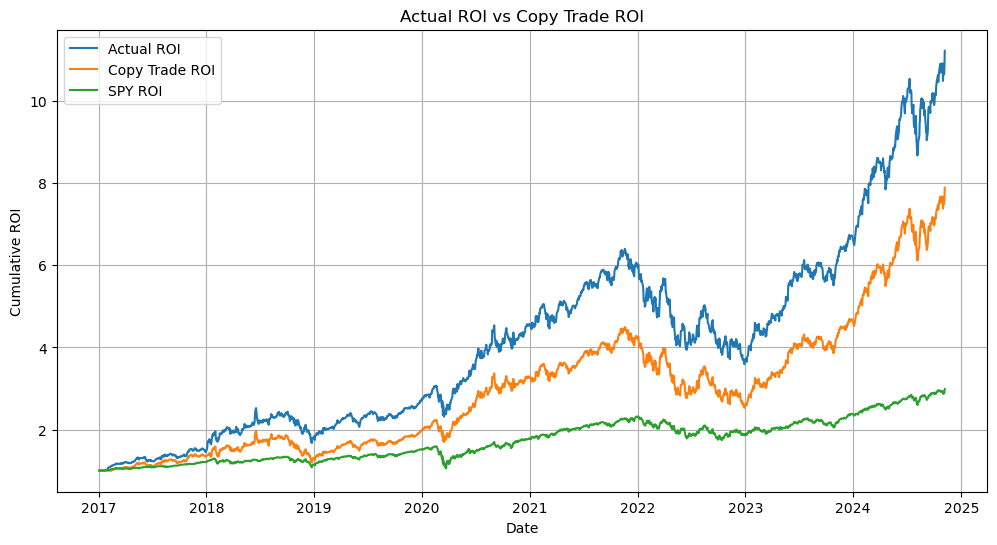

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio_roi['Date'], portfolio_roi['CumulativeROI'], label='Actual ROI')
plt.plot(portfolio_roi['Date'], portfolio_roi['CopyCumulativeROI'], label='Copy Trade ROI')
plt.plot(portfolio_roi['Date'], portfolio_roi['SPYCumROI'], label='SPY ROI')
plt.xlabel('Date')
plt.ylabel('Cumulative ROI')
plt.title('Actual ROI vs Copy Trade ROI')
plt.legend()
plt.grid(True)
plt.show()